In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

/opt/conda/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'metrics_bed_tiny_2/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('Squeeze Classifier. First Test.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                #img = aug['image'] / 255.0
                img = aug['image'] 
            except:
                #print(f'Error trying to augment image {img_file}')
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0) - 0.5 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
                aug = self.except_transform(image=img)
                img = aug['image'] 
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['.ipynb_checkpoints', 'labels', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

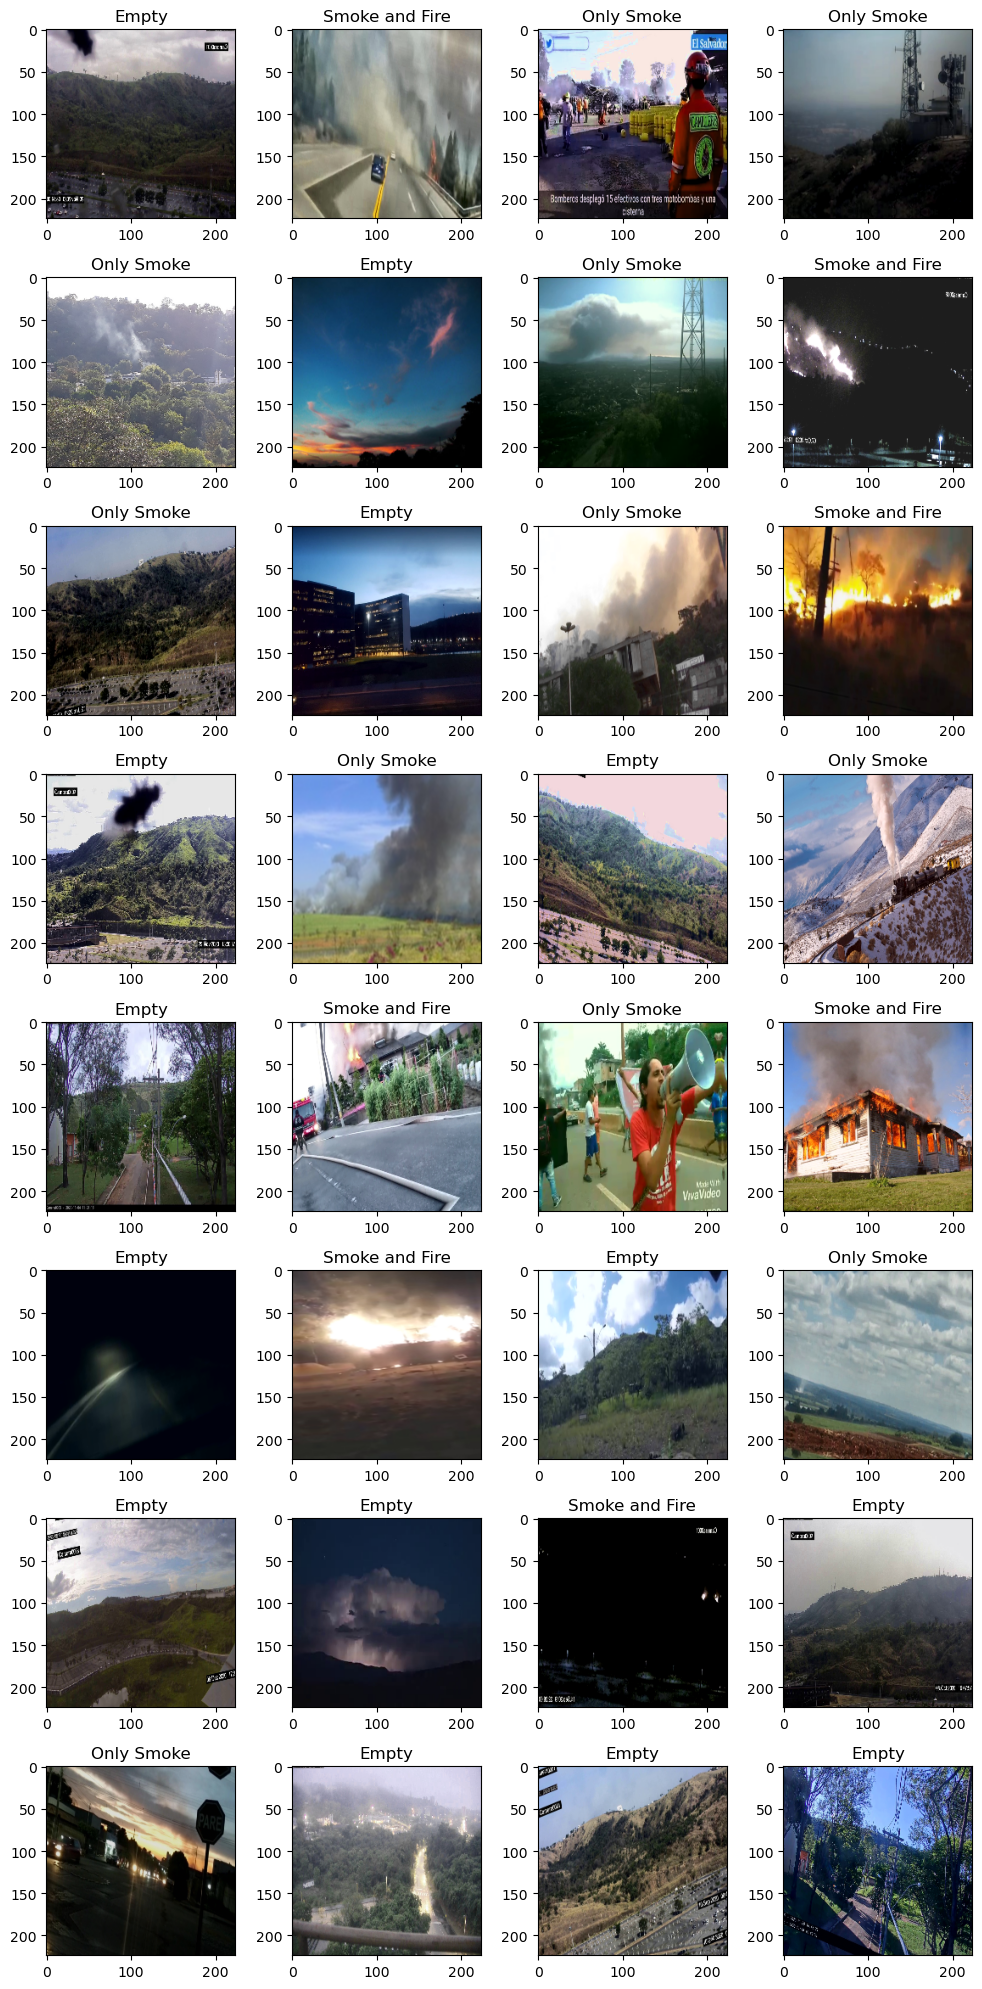

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             #nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device):
        super(BCE_LOSS, self).__init__()
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.bce = nn.BCEWithLogitsLoss(reduction='sum')
        self.mse = nn.MSELoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce(predictions[..., 0],
                              ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce(predictions[..., 1],
                             ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = 2*smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': 2*self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 75 #100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + "bed_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + "squeeze_classifier_best.pt"

LOSS_FN = "BCE"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.1679,  0.1208],
        [-0.1943,  0.0440],
        [-0.1775,  0.1494],
        [-0.2532,  0.0726]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [18]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        loss_fn = BCE_LOSS(device=DEVICE)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_bed_classifier.pt')    
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [ ]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    squeeze_model = main()

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE

***Start Training: 14:31:48

Initializing Weights

=== EPOCH 0/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
117.904     |87.442      |30.462      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
108.596     |84.777      |23.818      

SMOKE -> Precision: 0.621 - Recall: 0.458 - Accuracy: 0.605 - F1: 0.527
FIRE -> Precision: 0.724 - Recall: 0.366 - Accuracy: 0.800 - F1: 0.486

Saving model with new best validation loss: 108.596

=== EPOCH 1/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:53<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
109.195     |84.219      |24.975      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
105.226     |81.730      |23.496      

SMOKE -> Precision: 0.579 - Recall: 0.863 - Accuracy: 0.632 - F1: 0.693
FIRE -> Precision: 0.728 - Recall: 0.723 - Accuracy: 0.858 - F1: 0.725

Saving model with new best validation loss: 105.226

=== EPOCH 2/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:53<00:00,  2.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
101.055     |79.607      |21.449      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
91.333      |73.620      |17.713      

SMOKE -> Precision: 0.693 - Recall: 0.641 - Accuracy: 0.690 - F1: 0.666
FIRE -> Precision: 0.747 - Recall: 0.771 - Accuracy: 0.873 - F1: 0.759

Saving model with new best validation loss: 91.333

=== EPOCH 3/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
95.981      |76.570      |19.411      



Validating: 100%|██████████| 67/67 [00:16<00:00,  3.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
84.802      |69.410      |15.392      

SMOKE -> Precision: 0.706 - Recall: 0.688 - Accuracy: 0.712 - F1: 0.697
FIRE -> Precision: 0.801 - Recall: 0.808 - Accuracy: 0.898 - F1: 0.804

Saving model with new best validation loss: 84.802

=== EPOCH 4/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
92.122      |73.798      |18.323      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
82.244      |67.793      |14.451      

SMOKE -> Precision: 0.755 - Recall: 0.623 - Accuracy: 0.721 - F1: 0.682
FIRE -> Precision: 0.811 - Recall: 0.832 - Accuracy: 0.906 - F1: 0.822

Saving model with new best validation loss: 82.244

=== EPOCH 5/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
88.701      |71.621      |17.080      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
80.044      |66.551      |13.493      

SMOKE -> Precision: 0.759 - Recall: 0.676 - Accuracy: 0.741 - F1: 0.715
FIRE -> Precision: 0.884 - Recall: 0.805 - Accuracy: 0.922 - F1: 0.842

Saving model with new best validation loss: 80.044

=== EPOCH 6/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
85.794      |69.210      |16.584      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
75.934      |62.242      |13.692      

SMOKE -> Precision: 0.749 - Recall: 0.771 - Accuracy: 0.765 - F1: 0.760
FIRE -> Precision: 0.935 - Recall: 0.741 - Accuracy: 0.920 - F1: 0.827

Saving model with new best validation loss: 75.934

=== EPOCH 7/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
83.297      |67.375      |15.922      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.632      |62.333      |12.299      

SMOKE -> Precision: 0.820 - Recall: 0.640 - Accuracy: 0.759 - F1: 0.719
FIRE -> Precision: 0.915 - Recall: 0.800 - Accuracy: 0.929 - F1: 0.854

Saving model with new best validation loss: 74.632

=== EPOCH 8/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
82.515      |66.737      |15.778      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.362      |60.831      |13.530      

SMOKE -> Precision: 0.853 - Recall: 0.611 - Accuracy: 0.762 - F1: 0.712
FIRE -> Precision: 0.884 - Recall: 0.777 - Accuracy: 0.916 - F1: 0.827

Saving model with new best validation loss: 74.362

=== EPOCH 9/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
79.027      |63.959      |15.068      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
70.497      |58.848      |11.649      

SMOKE -> Precision: 0.732 - Recall: 0.868 - Accuracy: 0.783 - F1: 0.794
FIRE -> Precision: 0.877 - Recall: 0.864 - Accuracy: 0.933 - F1: 0.870

Saving model with new best validation loss: 70.497

=== EPOCH 10/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
77.730      |62.708      |15.022      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.731      |57.227      |11.504      

SMOKE -> Precision: 0.730 - Recall: 0.894 - Accuracy: 0.790 - F1: 0.804
FIRE -> Precision: 0.861 - Recall: 0.869 - Accuracy: 0.930 - F1: 0.865

Saving model with new best validation loss: 68.731

=== EPOCH 11/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
76.280      |61.699      |14.581      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.560      |52.259      |11.302      

SMOKE -> Precision: 0.771 - Recall: 0.866 - Accuracy: 0.812 - F1: 0.816
FIRE -> Precision: 0.929 - Recall: 0.822 - Accuracy: 0.938 - F1: 0.872

Saving model with new best validation loss: 63.560

=== EPOCH 12/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
74.749      |60.493      |14.257      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.677      |49.867      |10.809      

SMOKE -> Precision: 0.828 - Recall: 0.829 - Accuracy: 0.835 - F1: 0.829
FIRE -> Precision: 0.887 - Recall: 0.881 - Accuracy: 0.940 - F1: 0.884

Saving model with new best validation loss: 60.677

=== EPOCH 13/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:50<00:00,  2.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
73.012      |58.899      |14.113      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.123      |50.053      |11.070      

SMOKE -> Precision: 0.821 - Recall: 0.829 - Accuracy: 0.830 - F1: 0.825
FIRE -> Precision: 0.927 - Recall: 0.818 - Accuracy: 0.936 - F1: 0.869

=== EPOCH 14/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
71.708      |57.839      |13.869      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.866      |51.943      |10.923      

SMOKE -> Precision: 0.885 - Recall: 0.694 - Accuracy: 0.809 - F1: 0.778
FIRE -> Precision: 0.933 - Recall: 0.825 - Accuracy: 0.939 - F1: 0.876

=== EPOCH 15/74 ===
Learning Rate = 0.001



Training: 100%|██████████| 269/269 [01:50<00:00,  2.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
71.654      |57.827      |13.826      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.848      |49.991      |11.857      

SMOKE -> Precision: 0.864 - Recall: 0.748 - Accuracy: 0.822 - F1: 0.802
FIRE -> Precision: 0.928 - Recall: 0.805 - Accuracy: 0.933 - F1: 0.862

=== EPOCH 16/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:50<00:00,  2.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.016      |55.640      |13.375      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.87it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.461      |47.088      |10.373      

SMOKE -> Precision: 0.836 - Recall: 0.847 - Accuracy: 0.846 - F1: 0.841
FIRE -> Precision: 0.895 - Recall: 0.872 - Accuracy: 0.940 - F1: 0.883

Saving model with new best validation loss: 57.461

=== EPOCH 17/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
67.305      |54.254      |13.052      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.231      |44.151      |10.080      

SMOKE -> Precision: 0.836 - Recall: 0.883 - Accuracy: 0.860 - F1: 0.859
FIRE -> Precision: 0.903 - Recall: 0.874 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 54.231

=== EPOCH 18/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
66.041      |53.164      |12.877      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.532      |43.431      |10.101      

SMOKE -> Precision: 0.867 - Recall: 0.843 - Accuracy: 0.862 - F1: 0.855
FIRE -> Precision: 0.894 - Recall: 0.883 - Accuracy: 0.943 - F1: 0.888

Saving model with new best validation loss: 53.532

=== EPOCH 19/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:53<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.690      |52.869      |12.821      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.768      |45.027      |9.741       

SMOKE -> Precision: 0.874 - Recall: 0.809 - Accuracy: 0.852 - F1: 0.840
FIRE -> Precision: 0.920 - Recall: 0.879 - Accuracy: 0.949 - F1: 0.899

=== EPOCH 20/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:53<00:00,  2.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
65.633      |52.895      |12.738      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.578      |43.688      |9.890       

SMOKE -> Precision: 0.817 - Recall: 0.900 - Accuracy: 0.855 - F1: 0.857
FIRE -> Precision: 0.922 - Recall: 0.859 - Accuracy: 0.945 - F1: 0.890

=== EPOCH 21/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:52<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
64.178      |51.442      |12.735      



Validating: 100%|██████████| 67/67 [00:16<00:00,  3.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.418      |40.320      |9.098       

SMOKE -> Precision: 0.846 - Recall: 0.895 - Accuracy: 0.871 - F1: 0.870
FIRE -> Precision: 0.909 - Recall: 0.907 - Accuracy: 0.952 - F1: 0.908

Saving model with new best validation loss: 49.418

=== EPOCH 22/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.851      |50.432      |12.420      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.588      |41.331      |9.257       

SMOKE -> Precision: 0.893 - Recall: 0.818 - Accuracy: 0.865 - F1: 0.854
FIRE -> Precision: 0.925 - Recall: 0.883 - Accuracy: 0.951 - F1: 0.904

=== EPOCH 23/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.499      |50.244      |12.255      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.003      |41.653      |11.349      

SMOKE -> Precision: 0.880 - Recall: 0.823 - Accuracy: 0.861 - F1: 0.851
FIRE -> Precision: 0.954 - Recall: 0.784 - Accuracy: 0.934 - F1: 0.861

=== EPOCH 24/74 ===
Learning Rate = 0.0008



Training: 100%|██████████| 269/269 [01:52<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.568      |49.182      |12.386      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.717      |41.201      |9.517       

SMOKE -> Precision: 0.829 - Recall: 0.905 - Accuracy: 0.865 - F1: 0.865
FIRE -> Precision: 0.919 - Recall: 0.874 - Accuracy: 0.948 - F1: 0.896

=== EPOCH 25/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:51<00:00,  2.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.321      |48.632      |11.689      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.674      |38.499      |9.175       

SMOKE -> Precision: 0.886 - Recall: 0.844 - Accuracy: 0.873 - F1: 0.865
FIRE -> Precision: 0.894 - Recall: 0.912 - Accuracy: 0.949 - F1: 0.903

Saving model with new best validation loss: 47.674

=== EPOCH 26/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.346      |47.330      |12.016      



Validating: 100%|██████████| 67/67 [00:16<00:00,  3.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.276      |38.533      |9.743       

SMOKE -> Precision: 0.919 - Recall: 0.821 - Accuracy: 0.879 - F1: 0.867
FIRE -> Precision: 0.960 - Recall: 0.832 - Accuracy: 0.948 - F1: 0.891

=== EPOCH 27/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:54<00:00,  2.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.014      |48.185      |11.828      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.361      |36.490      |8.872       

SMOKE -> Precision: 0.895 - Recall: 0.877 - Accuracy: 0.891 - F1: 0.886
FIRE -> Precision: 0.949 - Recall: 0.859 - Accuracy: 0.952 - F1: 0.902

Saving model with new best validation loss: 45.361

=== EPOCH 28/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:52<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.844      |45.996      |11.848      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.333      |35.461      |8.872       

SMOKE -> Precision: 0.884 - Recall: 0.894 - Accuracy: 0.892 - F1: 0.889
FIRE -> Precision: 0.905 - Recall: 0.915 - Accuracy: 0.953 - F1: 0.910

Saving model with new best validation loss: 44.333

=== EPOCH 29/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.372      |46.355      |12.016      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.631      |39.791      |8.839       

SMOKE -> Precision: 0.810 - Recall: 0.946 - Accuracy: 0.867 - F1: 0.873
FIRE -> Precision: 0.912 - Recall: 0.912 - Accuracy: 0.954 - F1: 0.912

=== EPOCH 30/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:50<00:00,  2.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.342      |44.853      |11.489      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.101      |36.352      |9.748       

SMOKE -> Precision: 0.910 - Recall: 0.854 - Accuracy: 0.889 - F1: 0.881
FIRE -> Precision: 0.955 - Recall: 0.819 - Accuracy: 0.943 - F1: 0.882

=== EPOCH 31/74 ===
Learning Rate = 0.00064



Training: 100%|██████████| 269/269 [01:51<00:00,  2.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.468      |44.216      |11.252      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.435      |36.685      |8.751       

SMOKE -> Precision: 0.904 - Recall: 0.851 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.927 - Recall: 0.889 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 32/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.978      |44.591      |11.387      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.474      |35.053      |8.421       

SMOKE -> Precision: 0.913 - Recall: 0.850 - Accuracy: 0.889 - F1: 0.880
FIRE -> Precision: 0.949 - Recall: 0.863 - Accuracy: 0.953 - F1: 0.904

Saving model with new best validation loss: 43.474

=== EPOCH 33/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:53<00:00,  2.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.729      |43.628      |11.101      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.117      |34.052      |9.066       

SMOKE -> Precision: 0.882 - Recall: 0.895 - Accuracy: 0.892 - F1: 0.889
FIRE -> Precision: 0.959 - Recall: 0.848 - Accuracy: 0.951 - F1: 0.900

Saving model with new best validation loss: 43.117

=== EPOCH 34/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.686      |42.649      |11.037      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.414      |35.054      |8.359       

SMOKE -> Precision: 0.914 - Recall: 0.838 - Accuracy: 0.884 - F1: 0.874
FIRE -> Precision: 0.928 - Recall: 0.898 - Accuracy: 0.956 - F1: 0.913

=== EPOCH 35/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:53<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.534      |42.412      |11.122      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.725      |33.362      |8.363       

SMOKE -> Precision: 0.882 - Recall: 0.908 - Accuracy: 0.897 - F1: 0.895
FIRE -> Precision: 0.933 - Recall: 0.889 - Accuracy: 0.955 - F1: 0.911

Saving model with new best validation loss: 41.725

=== EPOCH 36/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.204      |42.398      |10.805      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.308      |36.835      |8.472       

SMOKE -> Precision: 0.921 - Recall: 0.823 - Accuracy: 0.881 - F1: 0.869
FIRE -> Precision: 0.920 - Recall: 0.895 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 37/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.993      |42.158      |10.835      



Validating: 100%|██████████| 67/67 [00:16<00:00,  3.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.414      |33.583      |8.831       

SMOKE -> Precision: 0.884 - Recall: 0.904 - Accuracy: 0.897 - F1: 0.894
FIRE -> Precision: 0.945 - Recall: 0.862 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 38/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.346      |41.710      |10.636      



Validating: 100%|██████████| 67/67 [00:16<00:00,  3.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.069      |31.602      |8.467       

SMOKE -> Precision: 0.912 - Recall: 0.886 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.932 - Recall: 0.883 - Accuracy: 0.953 - F1: 0.907

Saving model with new best validation loss: 40.069

=== EPOCH 39/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.708      |40.872      |10.836      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.459      |32.354      |8.105       

SMOKE -> Precision: 0.891 - Recall: 0.906 - Accuracy: 0.902 - F1: 0.899
FIRE -> Precision: 0.923 - Recall: 0.893 - Accuracy: 0.953 - F1: 0.908

=== EPOCH 40/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.252      |41.367      |10.885      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.189      |36.924      |8.265       

SMOKE -> Precision: 0.924 - Recall: 0.837 - Accuracy: 0.888 - F1: 0.878
FIRE -> Precision: 0.930 - Recall: 0.890 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 41/74 ===
Learning Rate = 0.0005120000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.156      |40.690      |10.466      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.108      |33.432      |8.676       

SMOKE -> Precision: 0.869 - Recall: 0.926 - Accuracy: 0.897 - F1: 0.897
FIRE -> Precision: 0.896 - Recall: 0.920 - Accuracy: 0.952 - F1: 0.908

=== EPOCH 42/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.977      |40.440      |10.537      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.765      |31.512      |8.253       

SMOKE -> Precision: 0.893 - Recall: 0.903 - Accuracy: 0.901 - F1: 0.898
FIRE -> Precision: 0.953 - Recall: 0.862 - Accuracy: 0.953 - F1: 0.905

Saving model with new best validation loss: 39.765

=== EPOCH 43/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.659      |39.169      |10.490      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.192      |31.751      |8.441       

SMOKE -> Precision: 0.908 - Recall: 0.892 - Accuracy: 0.905 - F1: 0.900
FIRE -> Precision: 0.949 - Recall: 0.873 - Accuracy: 0.955 - F1: 0.909

=== EPOCH 44/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [01:53<00:00,  2.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.976      |39.957      |10.018      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.788      |30.647      |8.140       

SMOKE -> Precision: 0.922 - Recall: 0.886 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.915 - Recall: 0.903 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 38.788

=== EPOCH 45/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [01:54<00:00,  2.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.136      |39.089      |10.046      



Validating: 100%|██████████| 67/67 [00:16<00:00,  4.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.044      |30.725      |8.319       

SMOKE -> Precision: 0.890 - Recall: 0.918 - Accuracy: 0.906 - F1: 0.903
FIRE -> Precision: 0.923 - Recall: 0.899 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 46/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.427      |39.046      |10.381      



Validating: 100%|██████████| 67/67 [00:16<00:00,  3.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.172      |30.806      |8.367       

SMOKE -> Precision: 0.900 - Recall: 0.908 - Accuracy: 0.907 - F1: 0.904
FIRE -> Precision: 0.937 - Recall: 0.883 - Accuracy: 0.954 - F1: 0.909

=== EPOCH 47/74 ===
Learning Rate = 0.0004096000000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.717      |38.227      |10.490      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.859      |32.638      |8.221       

SMOKE -> Precision: 0.921 - Recall: 0.869 - Accuracy: 0.901 - F1: 0.894
FIRE -> Precision: 0.936 - Recall: 0.888 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 48/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.614      |37.512      |10.101      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.627      |30.746      |7.880       

SMOKE -> Precision: 0.878 - Recall: 0.938 - Accuracy: 0.908 - F1: 0.907
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 38.627

=== EPOCH 49/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:51<00:00,  2.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.186      |36.979      |10.207      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.394      |29.497      |7.897       

SMOKE -> Precision: 0.905 - Recall: 0.908 - Accuracy: 0.910 - F1: 0.906
FIRE -> Precision: 0.919 - Recall: 0.906 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 37.394

=== EPOCH 50/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:50<00:00,  2.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.667      |37.521      |10.147      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.774      |28.758      |8.016       

SMOKE -> Precision: 0.893 - Recall: 0.937 - Accuracy: 0.915 - F1: 0.914
FIRE -> Precision: 0.934 - Recall: 0.886 - Accuracy: 0.955 - F1: 0.910

Saving model with new best validation loss: 36.774

=== EPOCH 51/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:52<00:00,  2.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.649      |36.616      |10.033      



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.241      |28.059      |8.181       

SMOKE -> Precision: 0.910 - Recall: 0.926 - Accuracy: 0.920 - F1: 0.918
FIRE -> Precision: 0.955 - Recall: 0.866 - Accuracy: 0.955 - F1: 0.908

Saving model with new best validation loss: 36.241

=== EPOCH 52/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:56<00:00,  2.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.629      |37.606      |10.023      



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.415      |29.230      |8.185       

SMOKE -> Precision: 0.908 - Recall: 0.918 - Accuracy: 0.916 - F1: 0.913
FIRE -> Precision: 0.940 - Recall: 0.868 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 53/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:55<00:00,  2.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.067      |37.144      |9.922       



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.879      |28.772      |8.108       

SMOKE -> Precision: 0.919 - Recall: 0.906 - Accuracy: 0.916 - F1: 0.912
FIRE -> Precision: 0.932 - Recall: 0.889 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 54/74 ===
Learning Rate = 0.0003276800000000001



Training: 100%|██████████| 269/269 [01:55<00:00,  2.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.151      |36.229      |9.922       



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.363      |28.579      |7.784       

SMOKE -> Precision: 0.886 - Recall: 0.941 - Accuracy: 0.914 - F1: 0.913
FIRE -> Precision: 0.930 - Recall: 0.904 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 55/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [01:56<00:00,  2.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.550      |35.839      |9.711       



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.035      |28.980      |8.055       

SMOKE -> Precision: 0.895 - Recall: 0.937 - Accuracy: 0.917 - F1: 0.915
FIRE -> Precision: 0.933 - Recall: 0.892 - Accuracy: 0.955 - F1: 0.912

=== EPOCH 56/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [01:55<00:00,  2.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.556      |35.992      |9.565       



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.717      |28.809      |7.908       

SMOKE -> Precision: 0.909 - Recall: 0.921 - Accuracy: 0.917 - F1: 0.915
FIRE -> Precision: 0.935 - Recall: 0.888 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 57/74 ===
Learning Rate = 0.0002621440000000001



Training: 100%|██████████| 269/269 [01:54<00:00,  2.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.027      |36.223      |9.804       



Validating: 100%|██████████| 67/67 [00:17<00:00,  3.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.997      |29.412      |8.585       

SMOKE -> Precision: 0.923 - Recall: 0.898 - Accuracy: 0.915 - F1: 0.910
FIRE -> Precision: 0.952 - Recall: 0.859 - Accuracy: 0.952 - F1: 0.903

=== EPOCH 58/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [01:56<00:00,  2.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.656      |35.179      |9.477       



Validating: 100%|██████████| 67/67 [00:18<00:00,  3.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.120      |29.210      |7.909       

SMOKE -> Precision: 0.899 - Recall: 0.923 - Accuracy: 0.913 - F1: 0.911
FIRE -> Precision: 0.918 - Recall: 0.914 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 59/74 ===
Learning Rate = 0.00020971520000000012



Training: 100%|██████████| 269/269 [01:58<00:00,  2.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.010      |35.302      |9.708       



Validating:   7%|▋         | 5/67 [00:02<00:26,  2.32it/s]

# Confusion Matrix

In [ ]:
conf_mtx_metric = torchmetrics.classification.MultilabelConfusionMatrix(num_labels = N_CLASSES, 
                                                                        threshold = 0.5).to(DEVICE)

In [ ]:
def get_conf_mtx(loader, model, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)  
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        conf_mtx_metric.update(yhat, y)
    
    conf_mtx = conf_mtx_metric.compute()
    conf_mtx_metric.reset()
    
    return conf_mtx

In [ ]:
conf_mtx = get_conf_mtx(loader=val_loader,
                        model=squeeze_model,
                        device=DEVICE)
print(conf_mtx)

In [ ]:
# conf_mtx = get_conf_mtx(loader=conf_loader,
#                         model=squeeze_model,
#                         device=DEVICE)
# smoke_conf_mtx = conf_mtx[0]
# fire_conf_mtx = conf_mtx[1]

### Smoke confusion matrix

### Fire confusion matrix

In [ ]:
# val_transform = A.Compose([
#     A.Resize(IMG_H, IMG_W, p=1),
#     #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
#     ToTensorV2(p=1),
#     ]
# )

# val_dataset = DFireDataset(img_h = IMG_H,
#                            img_w = IMG_W,
#                            img_dir = VAL_IMG_DIR,
#                            label_dir = VAL_LABEL_DIR,
#                            num_classes = N_CLASSES,
#                            ds_len=512,
#                            transform=val_transform)

# # LOADER
# plot_loader = DataLoader(dataset=val_dataset,
#                          batch_size=BATCH_SIZE,
#                          num_workers=NUM_WORKERS,
#                          pin_memory=PIN_MEMORY,
#                          shuffle=True,
#                          drop_last=True)



In [ ]:
# view_model = BED_CLASSIFIER(num_classes=N_CLASSES)
# model_file = log_path + 'bed_classifier_5epoch.pt'

# print(model_file)

# checkpoint = torch.load(model_file, map_location=torch.device('cpu'))
# view_model.load_state_dict(checkpoint['model_state_dict'])

# view_model.eval() 

In [ ]:
# import matplotlib.patches as patches 

In [ ]:
# for i, (img, label) in enumerate(plot_loader):

#     fig, ax = plt.subplots(1,4, figsize=(10, 20))
#     print(ax.shape)
#     for idx in range(4):
#             plt.subplot(1, 4, idx+1)
#             plt.imshow(img[idx].permute(1, 2, 0))

#             label_txt = ""
#             print(f'Label: {label[idx]}')
#             if label[idx, 0] == 1 and label[idx, 1] == 1:
#                 label_txt += "Smoke and Fire"
#             elif label[idx, 0] == 1 and label[idx, 1] == 0:
#                 label_txt += "Only Smoke"
#             elif label[idx, 0] == 0 and label[idx, 1] == 1:
#                 label_txt += "Only Fire"
#             else:
#                 label_txt += "Empty"

#             pred = torch.sigmoid( view_model(img[idx].unsqueeze(dim=0) / 255.) )
#             print(f'Pred: {pred}')
#             pred_txt = ""
#             if pred[..., 0] > 0.5 and pred[..., 1] > 0.5:
#                 pred_txt += "Smoke and Fire"
#             elif pred[..., 0] > 0.5 and pred[..., 1] < 0.5:
#                 pred_txt += "Only Smoke"
#             elif pred[..., 0] < 0.5 and pred[..., 1] > 0.5:
#                 pred_txt += "Only Fire"
#             else:
#                 pred_txt += "Empty"

#             if pred_txt == label_txt:
#                 rect = patches.Rectangle((1, 1), IMG_W-3, IMG_W-3, linewidth=3, edgecolor='g', facecolor="none")
#             else:
#                 rect = patches.Rectangle((1, 1), IMG_W-3, IMG_H-3, linewidth=3, edgecolor='r', facecolor="none")
                
#             ax[idx].add_patch(rect)
            
#             title = "Label: " + label_txt + " | Pred: " + pred_txt
#             plt.title(title, fontsize=8)

#             if (idx == 4):
#                 break
#     plt.tight_layout()
#     plt.show()
#     break

# Plot Results

In [ ]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss (*2)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()